<a href="https://colab.research.google.com/github/rakibulhaque9954/sentiment-analysis-imdb/blob/main/Conv1D_Word2Vec_sentiment_analysis_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Layer
from keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

In [74]:
train_dataset, val_dataset, test_dataset = tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)


In [3]:
for review, label in train_dataset.take(10):
  print("Review", review)
  print("Label", label.numpy())



Review tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label 0
Review tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I

In [4]:
def standardization(input_data):
  """Input: Raw Data(review, etc)
     Output: Standardized Data(review, etc)
     conversion to lower case for data regualrity,
     removal of html tags,
     regex means regularization text,
     removal of punctuations,
     removal of special characters,
     remove accented characters,
     stemming for example: discussion, discussed, discussing are the same word from the root discuss
     lemmatization for example: tensed when reduced to stem its tens which makes no sense, thats why lemmatization
     is used to provide the base for of the word, in this case tensed is turned into a lemma which is tense(again this two methods
     have their own use cases depending on the scenario)
  """
  lower_case = tf.strings.lower(input_data)
  html_tags = tf.strings.regex_replace(lower_case, '<[^>]+>', ' ')
  output = tf.strings.regex_replace(html_tags, '[%s]' % re.escape(string.punctuation), ' ')


  return output




In [5]:
standardization(tf.constant("<u>Okay,</u> you have:<br /><br />Penelope Keith as Miss Herringbone-Tweed, B.B.E. (Backbone of England.) She\'s killed off in the first scene - that\'s right, folks; this show has no backbone!<br /><br />Peter O\'Toole as Ol\' Colonel Cricket from The First War and now the emblazered Lord of the Manor.<br /><br />Joanna Lumley as the ensweatered Lady of the Manor, 20 years younger than the colonel and 20 years past her own prime but still glamourous (Brit spelling, not mine) enough to have a toy-boy on the side. It\'s alright, they have Col."))

<tf.Tensor: shape=(), dtype=string, numpy=b' okay   you have   penelope keith as miss herringbone tweed  b b e   backbone of england   she s killed off in the first scene   that s right  folks  this show has no backbone   peter o toole as ol  colonel cricket from the first war and now the emblazered lord of the manor   joanna lumley as the ensweatered lady of the manor  20 years younger than the colonel and 20 years past her own prime but still glamourous  brit spelling  not mine  enough to have a toy boy on the side  it s alright  they have col '>

#Tokenization and Numericalization(Text Vectorization)

In [75]:
VOCABULARY_SIZE = 10000 # common and important 10000 words
SEQUENCE_LENGTH = 250 # basically length of output
EMBEDDING_DIM = 300



In [76]:
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
)

In [77]:
training_data = train_dataset.map(lambda x, y: x) # takes in review, label and outputs only reviews
vectorize_layer.adapt(training_data)



In [78]:
print(vectorize_layer.get_vocabulary())
print(len(vectorize_layer.get_vocabulary()))


['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 't', 'you', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what', 'some', 'good', 'can', 'more', 'she', 'when', 'very', 'up', 'time', 'no', 'even', 'my', 'would', 'which', 'story', 'only', 'really', 'see', 'their', 'had', 'we', 'were', 'me', 'well', 'than', 'much', 'get', 'bad', 'been', 'people', 'will', 'do', 'other', 'also', 'into', 'first', 'great', 'because', 'how', 'him', 'don', 'most', 'made', 'its', 'then', 'make', 'way', 'them', 'could', 'too', 'movies', 'any', 'after', 'think', 'characters', 'character', 'watch', 'two', 'films', 'seen', 'many', 'life', 'being', 'plot', 'acting', 'never', 'love', 'little', 'best', 'where', 'over', 'did', 'show', 'know', 'off', 'ever', 'man', 'does', 'here', 'better', 'your', 'end

In [79]:
for review, label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [80]:
def vectorizer(review, label):
  review = vectorize_layer(review)
  return review, label

In [81]:
train_dataset = train_dataset.map(vectorizer)
val_dataset = val_dataset.map(vectorizer)
test_dataset = test_dataset.map(vectorizer)





In [82]:
for review, label in train_dataset.take(1):
  print(review) # each token/word is given a id in the vocabulary as shown below
  print(label)

tf.Tensor(
[  11   14   35  429  392   18   89   21   29    1    9   34 1349 3254
   42  473    1  198   26   85  156   19   11  207  331   29   67  249
  214    9  474   59   67   85  113   97   24 5726   11   18   13  639
  762   11   18    7   35  396 8116  179 2455  416    2   90 1218  137
   70  147   54    2    1 7632   70  229   67 2941   16    1 2777    1
    1 1483 4948    3   41 3933  115 1581   17 3254   14  164   19    4
 1218  909 7983    9    4   18   12   14 4191    5  100  146 1211   10
  244  679   12   40   26   99   39   11 7120  272   13   39 1349 3254
   13   50  397   10   97 1195  857  145    8    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [83]:
BATCH_SIZE = 64

In [84]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)



<hr>


# Modeling


# Pretrained Word2Vec(Gensim)
- **CBOW and Skip-gram Model Architectures**
<hr>

<img src='https://www.researchgate.net/publication/342116902/figure/fig3/AS:901413097992195@1591925038782/Architecture-of-Word2Vec-models-CBOW-and-Skip-Gram-The-window-size-in-both-cases-ie.png'>
<hr>

In [19]:
word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [22]:
word2vec.vectors.shape

(3000000, 300)

In [20]:
word2vec.most_similar('movie')


[('film', 0.8676770329475403),
 ('movies', 0.8013108372688293),
 ('films', 0.7363011837005615),
 ('moive', 0.6830360889434814),
 ('Movie', 0.6693680286407471),
 ('horror_flick', 0.6577848792076111),
 ('sequel', 0.6577793955802917),
 ('Guy_Ritchie_Revolver', 0.650975227355957),
 ('romantic_comedy', 0.6413198709487915),
 ('flick', 0.6321909427642822)]

## Searching Dataset Vocabulary in Word2Vec Vocabulary

### Extracting Embeddings from pretrained model

In [30]:
pretrained_embeddings = []

In [31]:
def first_caps(word):
  return word[0].upper() + word[1:] # capslocking the first letter of the missed word in vectorize_layer vocab


In [32]:
for i in range(len(vectorize_layer.get_vocabulary())):
    try:
        pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
    except:
        print(vectorize_layer.get_vocabulary()[i])

        try:
          pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
          print('To Upper case')
        except:
          print('cant solve')
          pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))
          #### converting similar words to uppercase to match the vocab ####


    if i % 1000 == 0:
      print('i is == ', i)



cant solve
i is ==  0
[UNK]
cant solve
and
To Upper case
a
To Upper case
of
To Upper case
to
To Upper case
10
cant solve
20
cant solve
30
cant solve
80
cant solve
i is ==  1000
90
cant solve
15
cant solve
50
cant solve
100
cant solve
humour
To Upper case
70
cant solve
40
cant solve
11
cant solve
favourite
To Upper case
12
cant solve
theatre
To Upper case
keaton
To Upper case
80s
cant solve
60
cant solve
70s
cant solve
000
cant solve
tarzan
To Upper case
i is ==  2000
13
cant solve
welles
To Upper case
sinatra
To Upper case
hitchcock
To Upper case
14
cant solve
columbo
To Upper case
pacino
To Upper case
25
cant solve
lugosi
To Upper case
branagh
To Upper case
60s
cant solve
1950
cant solve
17
cant solve
sandler
To Upper case
1980
cant solve
2006
cant solve
2000
cant solve
1970
cant solve
bettie
To Upper case
stanwyck
To Upper case
2001
cant solve
i is ==  3000
brando
To Upper case
wwii
cant solve
matthau
To Upper case
grey
To Upper case
seagal
To Upper case
1950s
cant solve
widmark
To 

### Saving the Embedding File as numpy file

In [33]:
# np.save('/content/drive/MyDrive/Colab Notebooks/RNN(sentiment analysis)/pretrained_embeddings/pretrained_embeddings.npy', pretrained_embeddings)


### Loading the saved numpy embeddings

In [34]:
pretrained_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/RNN(sentiment analysis)/pretrained_embeddings/pretrained_embeddings.npy')


In [35]:
pretrained_embeddings.shape



(10000, 300)

## Model Building

In [57]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCABULARY_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_2 (Flatten)         (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                253984    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 328

## Model Compilation and Fitting


In [58]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])


In [59]:

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
391/391 [==============================] - 60s 144ms/step - loss: 0.6952 - accuracy: 0.5070 - val_loss: 0.6926 - val_accuracy: 0.5162
Epoch 2/10
391/391 [==============================] - 9s 24ms/step - loss: 0.6897 - accuracy: 0.5280 - val_loss: 0.6878 - val_accuracy: 0.5418
Epoch 3/10
391/391 [==============================] - 10s 25ms/step - loss: 0.5657 - accuracy: 0.6984 - val_loss: 0.4143 - val_accuracy: 0.8275
Epoch 4/10
391/391 [==============================] - 9s 24ms/step - loss: 0.3552 - accuracy: 0.8530 - val_loss: 0.3441 - val_accuracy: 0.8528
Epoch 5/10
391/391 [==============================] - 9s 22ms/step - loss: 0.2871 - accuracy: 0.8889 - val_loss: 0.3238 - val_accuracy: 0.8642
Epoch 6/10
391/391 [==============================] - 9s 24ms/step - loss: 0.2425 - accuracy: 0.9103 - val_loss: 0.3237 - val_accuracy: 0.8643
Epoch 7/10
391/391 [==============================] - 9s 24ms/step - loss: 0.2083 - accuracy: 0.9252 - val_loss: 0.3226 - val_accuracy: 0.8

# Evaluation and Testing

In [60]:
test_dataset=test_dataset.batch(BATCH_SIZE)

In [61]:
model.evaluate(test_dataset)


196/196 [==============================] - 4s 19ms/step - loss: 0.3555 - accuracy: 0.8654


[0.3555130064487457, 0.8653600215911865]

**Accuracy Increased to 87% approx.**

In [70]:
test_data = tf.data.Dataset.from_tensor_slices([["It was interesting in the first half i liked it, but after some of the action scenes it was same as the rest of movies and the plot was predictable"],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])






In [71]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [72]:
def positive_or_negative(prediction):
    if prediction > 0.5:
        return 'positive', prediction
    else:
        return 'negative', prediction


class_names = ['negative', 'positive']


In [73]:
predictions = model.predict(test_dataset)
for pred in predictions:
    value = positive_or_negative(tf.cast(pred, dtype=tf.float32))
    print(value)

2/2 [==============================] - 0s 3ms/step
('negative', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3789639], dtype=float32)>)
('positive', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5664707], dtype=float32)>)


# Confusion Matrix

In [ ]:
true_labels = []

predicted_labels = []

def predict_with_model(text_tensor):
    return model.predict(text_tensor)

# Iterate through the test dataset to collect true labels and make predictions
for text_tensor, label in test_dataset.take(2000):
    true_labels.append(label)
    # Expand dimensions to match the expected input shape
    text_tensor = tf.expand_dims(text_tensor, axis=0)
    predicted_label = predict_with_model(text_tensor)
    # binary classification with threshold 0.5
    predicted_label = 1 if predicted_label >= 0.5 else 0
    predicted_labels.append(predicted_label)

# Convert the true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


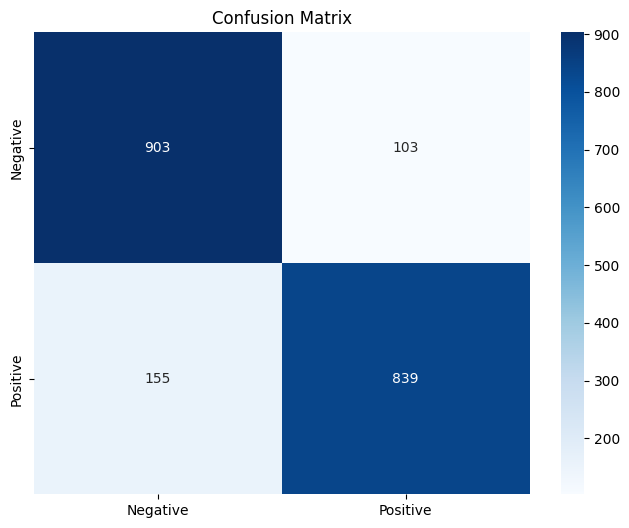

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.show()


# Model loss and accuracy

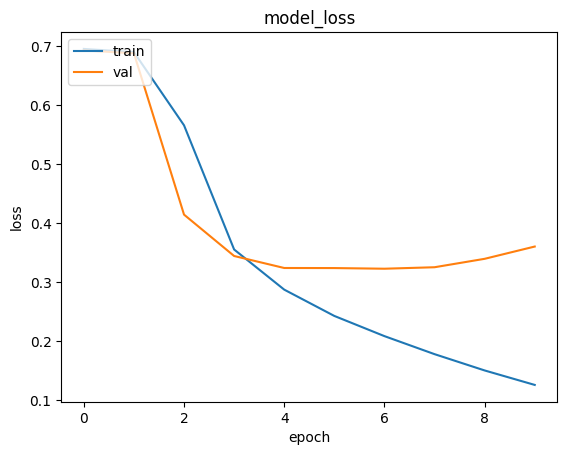

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

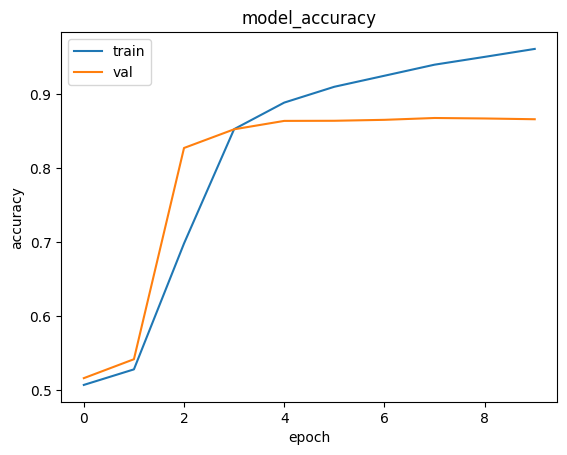

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Verdict

Using a pretrained model is very promising since the datapoints are quite large and generalization is better. Overall the accuracy and Confusion matrix showed promise over the LSTM and GRU model from scratch but none the less, different architectures play different roles for different problems.